<a href="https://colab.research.google.com/github/protontypes/osta/blob/main/packages_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install itables

In [2]:
import requests
import re
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


URL = "https://ost.ecosyste.ms/api/v1/projects/packages"
FILE_TO_SAVE_AS = "ecosystems_downloads.json" # the name you want to save file as

import os.path
resp = requests.get(URL) # making requests to server

with open(FILE_TO_SAVE_AS, "wb") as f: # opening a file handler to create new file
    f.write(resp.content) # writing content to file

In [3]:
import pandas as pd

# Define the S3 path to the Parquet file
s3_path = 's3://anaconda-package-data/conda/monthly/2024/2024-12.parquet'

# Load the Parquet file into a DataFrame
df_conda = pd.read_parquet(s3_path, engine='pyarrow')

In [4]:
def remove_jl_suffix(package_name):
    return re.sub(r'\.jl$', '', package_name)

def get_julia_package_downloads(package_name):
    """
    Fetch the monthly download statistics for a Julia package by name.

    Args:
        package_name (str): The name of the Julia package.

    Returns:
        dict: A dictionary containing download statistics or an error message.
    """
    package_name = remove_jl_suffix(package_name)
    
    try:
        # Define the URL for the Julia package statistics API
        url = f"https://juliapkgstats.com/api/v1/monthly_downloads/{package_name}"

        # Make the GET request
        response = requests.get(url)

        # Raise an exception for HTTP errors
        response.raise_for_status()

        # Parse the JSON response
        data = response.json()

        return {
            "package": package_name,
            "monthly_downloads": data.get("total_requests", "Data not available"),
            "details": data
        }

    except requests.exceptions.HTTPError as http_err:
        return {"error": f"HTTP error occurred: {http_err}"}
    except requests.exceptions.RequestException as req_err:
        return {"error": f"Request error occurred: {req_err}"}
    except Exception as e:
        return {"error": f"An error occurred: {e}"}

In [5]:
get_julia_package_downloads("OceanBioME")

{'package': 'OceanBioME',
 'monthly_downloads': '12',
 'details': {'total_requests': '12'}}

In [6]:
df = pd.read_json(resp.content.decode())

/tmp/ipykernel_134045/2574843592.py:1: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(resp.content.decode())



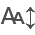

In [7]:
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

#df# GO packages do not provide montly download numbers. That's why we had to kick out kube-green

In [16]:
names = []
download_counts = []
url = []
description = []
category = []
sub_category = []
language = []
total_dependent_repos_count = []
stars = []
doi = []
citations = []
contributors = []
past_year_issues_count = []

for index, row in df.iterrows():
    names.append(row['name'])
    package_downloads = 0
    dependent_repos_count = 0
    for package_manager in range(len(row['packages'])):
        if row['packages'][package_manager]['downloads']:
                if row['packages'][package_manager]['downloads_period'] == "last-month":
                    package_downloads += row['packages'][package_manager]['downloads']
        if row['packages'][package_manager]['dependent_repos_count']:
                dependent_repos_count += row['packages'][package_manager]['dependent_repos_count']

    if row['language'] == "Julia":
        package_downloads = int(get_julia_package_downloads(row['name'])['monthly_downloads'])

    if row['language'] == "Python":
        conda_downloads = df_conda[df_conda['pkg_name'] == row['name']]['counts'].sum()
        package_downloads += int(conda_downloads)

    try:
        download_counts.append(package_downloads)
    except:
        download_counts.append(0)

    total_dependent_repos_count.append(dependent_repos_count)
    try:
        contributors.append(row['repository']['commit_stats']['total_committers'])
    except:
        contributors.append(0)
    stars.append(row['repository']['stargazers_count'])
    past_year_issues_count.append(row['issues_stats']['past_year_issues_count'])
    url.append(row['url'])
    description.append(row['description'])
    category.append(row['category'])
    sub_category.append(row['sub_category'])
    language.append(row['language'])
    citations.append(row['total_citations'])



In [40]:
df_extract = pd.DataFrame()
df_extract['project_names'] = names
df_extract['stars'] = stars
df_extract['citations'] = citations
df_extract['download_counts'] = download_counts
df_extract['dependent_repos'] = total_dependent_repos_count
df_extract['past_year_issues']=past_year_issues_count
df_extract['contributors'] = contributors
df_extract['git_url'] = url
df_extract['language'] = language
df_extract['description'] = description
df_extract['category'] = category
df_extract['sub_category'] = sub_category
df_extract.head(200)

project_names  stars  citations  download_counts  dependent_repos  past_year_issues  contributors                                            git_url          language                                        description                 category                               sub_category
0                                               xarray   3602          0          5345266            10016               726           547                   https://github.com/pydata/xarray            Python  An open source project and Python package that...           Climate Change                     Climate Data Standards
1                                        netcdf-python    763          0          1460811             4089                48            81          https://github.com/Unidata/netcdf4-python            Cython  The Unidata network Common Data Form (netCDF) ...           Climate Change                     Climate Data Standards
2                                             h5netcdf    184          0           868485              786                10            19               https://github.com/h5netcdf/h5netcdf            Python  A Python interface for the netCDF4 file format...           Climate Change                     Climate Data Standards
3                                         pvlib-python   1191        475           286033              150               202           129              https://github.com/pvlib/pvlib-python            Python  A set of documented functions for simulating t...         Renewable Energy             Photovoltaics and Solar Energy
4                                            entsoe-py    425          0           261331               28                80            60             https://github.com/EnergieID/entsoe-py            Python  A Python client for the ENTSO-E API (European ...           Energy Systems  Energy Data Accessibility and Integration
5                                     Meteostat Python    352          0           242288               41                14             2      https://github.com/meteostat/meteostat-python            Python  Access and analyze historical weather and clim...           Climate Change      Climate Data Access and Visualization
6                                               Py-ART    531          0           199844               29                59            84                   https://github.com/arm-doe/pyart            Python  A data model driven interactive toolkit for wo...               Atmosphere    Meteorological Observation and Forecast
7                                               Siphon    222          0           175146               98                15            29                  https://github.com/Unidata/siphon            Python  A collection of Python utilities for retrievin...  Sustainable Development               Data Catalogs and Interfaces
8                                               cfgrib    403          0           179341              224                24            25                    https://github.com/ecmwf/cfgrib            Python  A Python interface to map GRIB files to the Ne...           Climate Change       Climate Data Processing and Analysis
9                                      BikeshareClient      5          0                0                0                 0             4          https://github.com/andmos/BikeshareClient                C#  Dotnet library for integrating with GBFS bikes...              Consumption                Mobility and Transportation
10                                              cdsapi    243          0           138080              179                29            19                    https://github.com/ecmwf/cdsapi            Python  Python API to access the Copernicus Climate Da...           Climate Change      Climate Data Access and Visualization
11                                               xclim    330          2           125397               45           

In [41]:
df_extract_mod = df_extract[(df_extract['project_names'] == 'PyPSA') | (df_extract['project_names'] == 'OSeMOSYS') | (df_extract['project_names'] == 'GenX') | (df_extract['project_names'] == 'pandapower') | (df_extract['project_names'] == 'balmorel') | (df_extract['project_names'] == 'times_model') | (df_extract['project_names'] == 'switch-model') | (df_extract['project_names'] == 'PowerSystems.jl') | (df_extract['project_names'] == 'powersimulationsdynamics.jl') | (df_extract['project_names'] == 'PowSyBl Open Load Flow') | (df_extract['project_names'] == 'Antares Simulator') | (df_extract['project_names'] == 'SpineOpt.jl') | (df_extract['project_names'] == 'GridPath') | (df_extract['project_names'] == 'PyPowSyBl')]

In [42]:
df_extract_mod

project_names  stars  citations  download_counts  dependent_repos  past_year_issues  contributors                                            git_url language                                        description        category                       sub_category
32               pandapower    863          0            23413               75               122           156               https://github.com/e2niee/pandapower   Python  An easy to use open source tool for power syst...  Energy Systems  Energy System Modeling Frameworks
67                PyPowSyBl     56          0             7655                1                54            30               https://github.com/powsybl/pypowsybl     Java  A Python library for modelling and simulating ...  Energy Systems  Energy System Modeling Frameworks
78                    PyPSA   1239        238             6399               46                92            92                     https://github.com/PyPSA/PyPSA   Python  A free software toolbox for simulating and opt...  Energy Systems  Energy System Modeling Frameworks
588                GridPath     95          0              271                0                14            12            https://github.com/blue-marble/gridpath   Python  A versatile simulation and optimization platfo...  Energy Systems  Energy System Modeling Frameworks
788  PowSyBl Open Load Flow     48          0                0               20                33            39   https://github.com/powsybl/powsybl-open-loadflow     Java  An open source library written in Java, that m...  Energy Systems  Energy System Modeling Frameworks
808       Antares Simulator     58          0                0                0                95            32  https://github.com/antaressimulatorteam/antare...        C  An Open Source power system simulator to quant...  Energy Systems  Energy System Modeling Frameworks
879            switch-model    138          0                0                0                 0            16             https://github.com/switch-model/switch   Python  Optimal planning model for power systems with ...  Energy Systems       Renewable Energy Integration
934         PowerSystems.jl    308         15              105                0               118            42     https://github.com/nrel-sienna/powersystems.jl    Julia  Provides a rigorous data model using Julia str...  Energy Systems  Energy System Modeling Frameworks

In [43]:
import textwrap

def text_to_link(project_name, git_url):
    return '<a href="' + git_url + '" target="_blank" style = "color: black">' + str(project_name) + "</a>"

def text_to_bolt(topic):
    return "<b>" + topic + "</b>"

def line_break_text(text):
    wrapped_text = '<br>'.join(textwrap.wrap(text, 64))
    return wrapped_text

df_extract["description"] = df_extract.apply(
    lambda x: line_break_text(x.description), axis=1
)


df_extract["project_names"] = df_extract.apply(
    lambda x: text_to_link(x.project_names, x.git_url), axis=1
)
#df_extract

In [44]:
df_extract.reset_index(drop=True, inplace=True)

In [45]:
# df_extract = df_extract[df_extract["language"] == "Julia"]

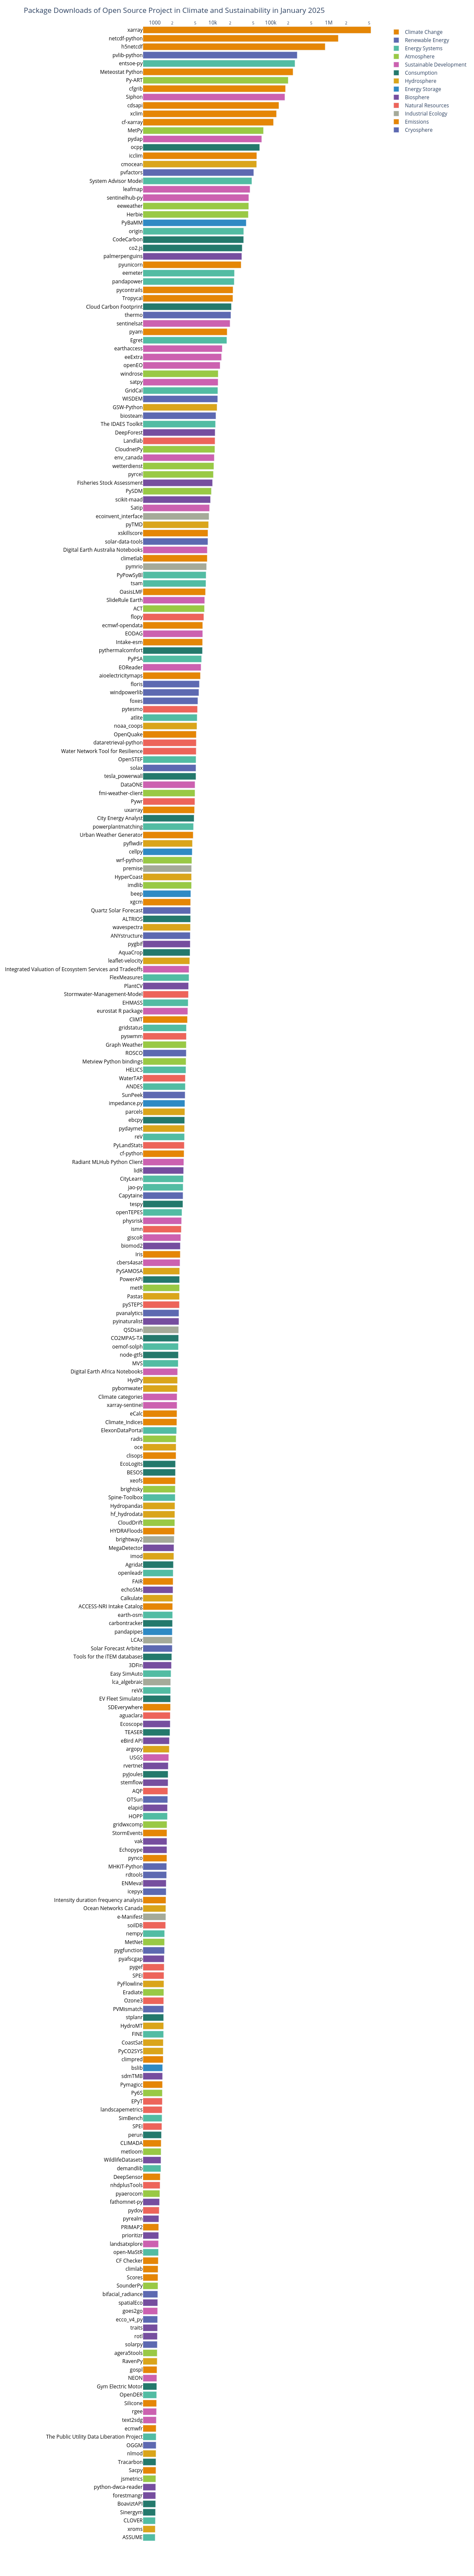

In [46]:
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime

# Get the current date
current_date = datetime.now()

# Format the date to display the full month and year
month_year = current_date.strftime("%B %Y")


#df_extract = df_extract[df_extract["category"] == "Renewable Energy"]

number_of_projects_to_show = 300
top_downloaders = df_extract.nlargest(number_of_projects_to_show, "download_counts")
top_downloaders.index.name = "ranking"
color_discrete_sequence = px.colors.qualitative.Vivid
fig = px.bar(
    top_downloaders,
    x=top_downloaders["download_counts"],
    y=top_downloaders["project_names"],
    custom_data=["project_names", "download_counts", "git_url", "description","dependent_repos","category","sub_category","language",top_downloaders.index+1],
    orientation="h",
    color = 'category',
    color_discrete_sequence=color_discrete_sequence,
)

fig.update_layout(
    height=number_of_projects_to_show*20,  # Added parameter
    #width=700,
    xaxis_title="",
    yaxis_title=None,
    title="Package Downloads of Open Source Project in Climate and Sustainability in "+month_year,
    dragmode=False,
)

fig.update_layout(hovermode="y unified",hoverdistance=1000)

fig.update_traces(
    hovertemplate="<extra></extra>"+"<br>".join(
        [
            "Ranking: <b>%{customdata[8]}</b>",
            "Description: <b>%{customdata[3]}</b>",
            "Category: <b>%{customdata[5]}</b>",
            "Sub Category: <b>%{customdata[6]}</b>",
            "Language: <b>%{customdata[7]}</b>",
            "Downloads per month: <b>%{customdata[1]}</b>",
            "Dependent Repositoris: <b>%{customdata[4]}</b>"
        ]
    )

)

#fig.update(layout_showlegend=False)

fig.update_layout(modebar=dict(bgcolor="rgba(0,0,0,0)"))

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
  },
  'responsive':'true'
}
fig.update_layout(
    plot_bgcolor='white'
)

fig.update_layout(modebar_color="#009485", modebar_activecolor="#2563eb")
fig["layout"]["yaxis"]["autorange"] = "reversed"

fig.update_xaxes(showspikes=False)  # <-- add this line
fig.update_yaxes(showspikes=False)  # <-- add this line
#fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
#                  plot_bgcolor = "rgba(0,0,0,0)")

#fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
fig.update_layout(xaxis_type = "log",yaxis_categoryorder = 'total descending',legend_title=None, xaxis={'side': 'top'}, )
#fig.show(config=config)

#pio.write_json(fig,"download_plot.json")
#pio.write_html(fig,"download_plot.html")


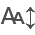

project_names  stars  citations  download_counts  dependent_repos  past_year_issues  contributors                                            git_url          language                                        description                 category                                    sub_category
3    <a href="https://github.com/pvlib/pvlib-python...   1191        475           286033              150               202           129              https://github.com/pvlib/pvlib-python            Python  A set of documented functions for simulating t...         Renewable Energy                  Photovoltaics and Solar Energy
11   <a href="https://github.com/ouranosinc/xclim" ...    330          2           125397               45               123            58                https://github.com/ouranosinc/xclim            Python  A library of derived climate variables, i.e. c...           Climate Change            Climate Data Processing and Analysis
23   <a href="https://github.com/blaylockbk/Herbie"...    491         77            41023                3                80            28               https://github.com/blaylockbk/Herbie            Python  A python package that downloads recent and arc...               Atmosphere         Meteorological Observation and Forecast
25   <a href="https://github.com/pybamm-team/pybamm...   1104        102            37735               13               327           127              https://github.com/pybamm-team/pybamm            Python  Fast and flexible physics-based battery models...           Energy Storage                                         Battery
40   <a href="https://github.com/iamconsortium/pyam...    230         19            17670               27                28            31              https://github.com/iamconsortium/pyam            Python  A Python package for data-wrangling, analysis ...           Climate Change        Integrated Assessment and Climate Policy
48   <a href="https://github.com/biosteamdevelopmen...    186         55            11312                3                10            12  https://github.com/biosteamdevelopmentgroup/bi...            Python  The Biorefinery Simulation and Techno-Economic...         Renewable Energy                                       Bioenergy
57   <a href="https://github.com/open-atmos/PySDM" ...     60        159             9453                2                80            33                https://github.com/open-atmos/PySDM            Python  Pythonic particle-based warm-rain/aqueous-chem...               Atmosphere               Atmospheric Chemistry and Aerosol
58   <a href="https://github.com/scikit-maad/scikit...    109         46             9122               68                10            14         https://github.com/scikit-maad/scikit-maad            Python  Enables quantitative analysis of environmental...                Biosphere         Bioacoustics and Acoustic Data Analysis
76   <a href="https://github.com/CenterForTheBuiltE...    154         56             6626                4                56             6  https://github.com/CenterForTheBuiltEnvironmen...            Python  Package to calculate several thermal comfort i...              Consumption                           Buildings and Heating
78   <a href="https://github.com/PyPSA/PyPSA" targe...   1239        238             6399               46                92            92                     https://github.com/PyPSA/PyPSA            Python  A free software toolbox for simulating and opt...           Energy Systems               Energy System Modeling Frameworks
84   <a href="https://github.com/modflowpy/flopy" t...    518        224             6992               45                72            71                 https://github.com/modflowpy/flopy            Python  A Python package to create, run, and post-proc...        Natural Resources                        Water Supply and Quality
94   <a href="https://github.com/pywr/pywr" target=...   

In [48]:
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)
df_extract.loc[df_extract['citations'] > 0]